# CCS Concept Tree

This Notebook create a database of labeled concept pairs based on the Computing Classification System of ACM.<br>
You can find the xml [here](https://dl.acm.org/pb-assets/dl_ccs/acm_ccs2012-1626988337597.xml). 

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import glob


from Scripts.util import cartesianProductOfLists, stringPreprocessing

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Read the AL-CPL Data

### Reading and Preprocessing of Prerequisites

In [2]:
data_path = 'Data/AL-CPL Dataset/'
path_list = [glob.glob(path) for path in [data_path + "*.preqs", data_path+"*.pairs"]]

preqs_csv = pd.DataFrame.from_dict({"kw1":[], "kw2":[]})

for path in path_list[0]:
    csv = pd.read_csv(path, names=['kw1', 'kw2'])
    preqs_csv = pd.concat([preqs_csv, csv], ignore_index=True)

preqs_csv.tail()

preprocessed = False

In [3]:
if(not preprocessed):
    kw1 =  preqs_csv['kw2'].apply(stringPreprocessing)
    kw2 =  preqs_csv['kw1'].apply(stringPreprocessing)
    preprocessed = True

In [4]:
preqs_csv['kw1'], preqs_csv['kw2'] = kw1, kw2
preqs_csv.tail()

,kw1,kw2
1997,point geometry,solution triangle
1998,integer,algebraic expression
1999,geometry,parallel geometry
2000,set mathematics,open set
2001,integer,homogeneous polynomial


### Reading and Preprocessing of all Pairs

In [5]:
pairs_csv = pd.DataFrame.from_dict({"kw1":[], "kw2":[]})

for path in path_list[1]:
    csv = pd.read_csv(path, names=['kw1', 'kw2'])
    pairs_csv = pd.concat([pairs_csv, csv], ignore_index=True)

preprocessed = False
pairs_csv.tail()

,kw1,kw2
6524,Polynomial,Natural_number
6525,Mathematics,Polynomial_long_division
6526,Multiplication,Minor_(linear_algebra)
6527,Trigonometric_substitution,Geometry
6528,Homogeneous_polynomial,Integer


In [6]:
if(not preprocessed):
    kw1 =  pairs_csv['kw2'].apply(stringPreprocessing)
    kw2 =  pairs_csv['kw1'].apply(stringPreprocessing)
    preprocessed = True

In [7]:
pairs_csv['kw1'], pairs_csv['kw2'] = kw1, kw2
pairs_csv.tail()

,kw1,kw2
6524,natural number,polynomial
6525,polynomial long division,mathematics
6526,minor linear algebra,multiplication
6527,geometry,trigonometric substitution
6528,integer,homogeneous polynomial


### Setting zeros and ones

In [8]:
preqs_csv['label'] = np.array([1 for i in range(preqs_csv.shape[0])])
preqs_csv.tail()

,kw1,kw2,label
1997,point geometry,solution triangle,1
1998,integer,algebraic expression,1
1999,geometry,parallel geometry,1
2000,set mathematics,open set,1
2001,integer,homogeneous polynomial,1


In [9]:
pairs_csv['label'] = np.array([0 for i in range(pairs_csv.shape[0])])
pairs_csv.tail()

,kw1,kw2,label
6524,natural number,polynomial,0
6525,polynomial long division,mathematics,0
6526,minor linear algebra,multiplication,0
6527,geometry,trigonometric substitution,0
6528,integer,homogeneous polynomial,0


### Merging both zeros and ones

###### Checking for redundancies

In [10]:
complete_dataset_csv = pd.merge(preqs_csv,pairs_csv, on=['kw1', 'kw2'], indicator=True, how='right')
complete_dataset_csv.loc[complete_dataset_csv['_merge'] == 'right_only', 'label_x'] = np.array(0)
complete_dataset_csv = complete_dataset_csv.rename(columns={'label_x':'label'}).drop(columns=['label_y', '_merge'])
complete_dataset_csv.value_counts()

kw1            kw2                          label
line geometry  parallel geometry            1.0      4
line segment   triangle                     1.0      4
perpendicular  cartesian coordinate system  1.0      4
circle         cone                         1.0      4
               chord geometry               1.0      4
                                                    ..
field physic   electric potential energy    1.0      1
               electric potential           1.0      1
               electric field               1.0      1
               electric current             0.0      1
zero function  prime number                 0.0      1
Length: 6375, dtype: int64

###### Removing redundancies

In [11]:
complete_dataset_csv = complete_dataset_csv.drop_duplicates(subset=['kw1', 'kw2'], keep='first')
complete_dataset_csv['label'].value_counts()

0.0    4442
1.0    1933
Name: label, dtype: int64

##### Save the created df:

In [12]:
complete_dataset_csv.to_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_ds.csv", index=False)

##### Load the data

In [38]:
complete_dataset_csv = pd.read_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_ds.csv")

### Building the graph with networkx

In [14]:
prereq = complete_dataset_csv[complete_dataset_csv['label'] == 1]
DG = nx.from_pandas_edgelist(prereq, source='kw1', target='kw2', edge_attr=True, create_using=nx.DiGraph())

nodes = DG.nodes()
len(nodes)

462

In [15]:
edges = DG.edges()
len(edges)

1933

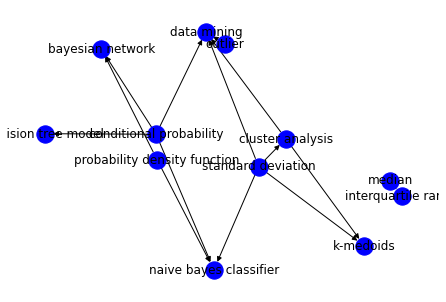

In [16]:
subgraph = DG.subgraph(list(nodes)[3:15])
pos = nx.spring_layout(subgraph)

nx.draw(subgraph, pos=pos, with_labels = True, node_color = 'b')
plt.show()

### Creating test and train set

In [20]:
## Selecting the nodes
root_test = "line geometry"

In [21]:
nodes = list(nx.nodes(nx.dfs_tree(DG, root_test)))

In [27]:
subgraph_test  = DG.subgraph(list(nodes))
subgraph_train = DG.copy()

nodes_to_remove = nodes

count_nodes_removed = len(nodes_to_remove)

subgraph_train.remove_nodes_from(nodes_to_remove)

In [29]:
print("Percentage of nodes in test set: {0:.2f}%".format(len(subgraph_test.nodes())/len(DG.nodes())*100))
print("Percentage of edges in test set: {0:.2f}%".format(len(subgraph_test.edges())/len(DG.edges())*100))
print("Percentage of nodes in training set: {0:.2f}%".format(len(subgraph_train.nodes())/len(DG.nodes())*100))
print("Percentage of edges in training set: {0:.2f}%".format(len(subgraph_train.edges())/len(DG.edges())*100))
print("percentage of edges lost due to split: {0:.2f}%".format(100 - len(subgraph_test.edges())/len(DG.edges())*100 - len(subgraph_train.edges())/len(DG.edges())*100))

Percentage of nodes in test set: 20.13%
Percentage of edges in test set: 19.09%
Percentage of nodes in training set: 79.87%
Percentage of edges in training set: 65.86%
percentage of edges lost due to split: 15.05%


#### Depth of Training and Testing graphs

In [27]:
print(nx.dag_longest_path_length(DG))
print(nx.dag_longest_path_length(subgraph_train))
print(nx.dag_longest_path_length(subgraph_test))

10
7
7


#### Splitting dataset into Training and Testing with respect to the nodes of the test subgraph

In [31]:
training_dataset_csv = complete_dataset_csv[~(complete_dataset_csv['kw1'].isin(nodes_to_remove) | complete_dataset_csv['kw2'].isin(nodes_to_remove))]
testing_dataset_csv  = complete_dataset_csv[(complete_dataset_csv['kw1'].isin(nodes_to_remove) | complete_dataset_csv['kw2'].isin(nodes_to_remove))]

In [39]:
print("Percentage of zeros in training dataset: {0:.2f}%".format(training_dataset_csv['label'].value_counts()[0]/training_dataset_csv.shape[0]*100))
print("Percentage of ones in training dataset: {0:.2f}%".format(training_dataset_csv['label'].value_counts()[1]/training_dataset_csv.shape[0]*100))
print("Percentage of zeros in testing dataset: {0:.2f}%".format(testing_dataset_csv['label'].value_counts()[0]/testing_dataset_csv.shape[0]*100))
print("Percentage of ones in testing dataset: {0:.2f}%".format(testing_dataset_csv['label'].value_counts()[1]/testing_dataset_csv.shape[0]*100))
print("Percentage of pairs lost due to split: {0:.2f}".format(100-testing_dataset_csv.shape[0]/complete_dataset_csv.shape[0]*100 - training_dataset_csv.shape[0]/complete_dataset_csv.shape[0]*100))

Percentage of zeros in training dataset: 70.41%
Percentage of ones in training dataset: 29.59%
Percentage of zeros in testing dataset: 68.16%
Percentage of ones in testing dataset: 31.84%
Percentage of pairs lost due to split: 0.00


Here, some concepts from the training dataset can be linked to the concepts of the testing dataset. However, in the testing dataset there is for sure 93 concepts never seen in the training dataset.

#### Saving the datasets

In [37]:
training_dataset_csv.to_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_trainig_ds.csv", index=False)
testing_dataset_csv.to_csv("Data/AL-CPL Dataset/Preprocessed_AL_CPL_testing_ds.csv", index=False)

### Stats On Geometry and Line Geometry

In [50]:
def averageOfAllSimplePathsFromRootInGraph(G, root_el):
    nodes_root = list(nx.nodes(nx.dfs_tree(G, root_el)))[1:]

    all_paths_from_root = []
    mean_len_path = 0
    for node in nodes_root:
        simple_paths = nx.all_simple_paths(G, source=root_el, target=node)
        all_paths_from_root += simple_paths

    return np.mean([len(path) for path in all_paths_from_root])

In [51]:
root = "geometry"
averageOfAllSimplePathsFromRootInGraph(DG, root)

5.279535697249165

In [53]:
averageOfAllSimplePathsFromRootInGraph(subgraph_train, root)

3.0

In [56]:
averageOfAllSimplePathsFromRootInGraph(subgraph_test, root_test)

4.284107946026986

In [57]:
averageOfAllSimplePathsFromRootInGraph(DG, root_test)

4.284107946026986

Faire un Tableau de mes tats